In [29]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [30]:
!pip install lightgbm


[notice] A new release of pip available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [31]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import QuantumKernel

In [32]:
import numpy as np
from sklearn import svm, metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.algorithms import VQC, QSVC
from sklearn.metrics import classification_report, confusion_matrix
from time import time
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

## Loading up the Datsets:

In [33]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')
train_data = train_data[:320]
train_labels = train_labels[:320]

## Training a Classical SVM model:

In [34]:
#training classical SVM with rbf kernel

print("*** Training a classical SVM classifier with rbf Kernel ***")

#converting two dimensional labels to 1D
train_labels_svm = train_labels[:,0]
test_labels_svm = test_labels[:,0]

clf = svm.SVC(kernel='rbf')
start_time = time()
clf.fit(train_data, train_labels_svm)
end_time = time()
duration = end_time - start_time
print("training time for classical SVM : ", duration)
y_pred=clf.predict(test_data)
print(confusion_matrix(test_labels_svm, y_pred))
print(classification_report(test_labels_svm, y_pred))

*** Training a classical SVM classifier with rbf Kernel ***
training time for classical SVM :  0.004880428314208984
[[9676  324]
 [ 559  441]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10000
           1       0.58      0.44      0.50      1000

    accuracy                           0.92     11000
   macro avg       0.76      0.70      0.73     11000
weighted avg       0.91      0.92      0.91     11000



In [35]:
# Output:
y_pred

array([1, 0, 0, ..., 0, 0, 0])

## Training a Hypertuned LGBM Model:

In [36]:
# Hyperparameter tuning for LGBMClassifier using RandomizedSearchCV
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
}

clf = lgb.LGBMClassifier()
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy')
random_search.fit(train_data, train_labels_svm)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

best_model = random_search.best_estimator_

# Training the best model on the appended train data
start_time = time()
best_model.fit(train_data, train_labels_svm)
end_time = time()
duration = end_time - start_time
print("Training time:", duration)

# Predicting on the appended test data using the best model
start_time1 = time()
y_pred_1 = best_model.predict(test_data)
end_time1 = time()
duration1 = end_time1 - start_time1
print("Testing time:", duration1)
print(classification_report(test_labels_svm, y_pred_1))
print(confusion_matrix(test_labels_svm, y_pred_1))

Best Parameters: {'num_leaves': 100, 'n_estimators': 200, 'learning_rate': 0.01}
Best Score: 0.9376065361782167
Training time: 0.21143269538879395
Testing time: 0.018830299377441406
              precision    recall  f1-score   support

           0       1.00      0.92      0.96     10000
           1       0.56      0.97      0.71      1000

    accuracy                           0.93     11000
   macro avg       0.78      0.94      0.83     11000
weighted avg       0.96      0.93      0.94     11000

[[9239  761]
 [  34  966]]


In [37]:
# Output:
y_pred_1

array([1, 1, 1, ..., 0, 0, 0])

## Training a SVM Model with Hyperparameter Tuning:

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

# Define the base classifiers
svm_classifier = svm.SVC(kernel='rbf')
quantum_kernel = QSVC(quantum_kernel=QuantumKernel(feature_map=ZZFeatureMap(train_data.shape[1]),
                                                   quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                                                                   shots=1,
                                                                                   seed_simulator=1376,
                                                                                   seed_transpiler=1376)))

# Define the pipeline for feature appending and model training
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional: Apply standard scaling
    ('classifier', svm_classifier),
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__C': [10.0, 10.0, 100.0, 100.0],
    'classifier__gamma': ['scale', 'auto',0.001, 0.01,0.1,1.0],
}

# Perform hyperparameter tuning using GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy')
grid_search.fit(train_data, train_labels_svm)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Train the best model
best_model.fit(train_data, train_labels_svm)

# Predict on the test data
y_pred = best_model.predict(test_data)
print(metrics.confusion_matrix(test_labels_svm, y_pred))
print(metrics.classification_report(test_labels_svm, y_pred))


/tmp/ipykernel_60/613815345.py:10: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),


Best Parameters: {'classifier__C': 100.0, 'classifier__gamma': 1.0}
Best Score: 0.8438840886381002
[[9386  614]
 [ 193  807]]
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     10000
           1       0.57      0.81      0.67      1000

    accuracy                           0.93     11000
   macro avg       0.77      0.87      0.81     11000
weighted avg       0.94      0.93      0.93     11000



In [39]:
# Output:
y_pred

array([1, 0, 1, ..., 0, 0, 0])

## Stacking with VQC as base classifier and QSVM as meta classifier

In [40]:
import numpy as np
from sklearn import svm, metrics
from sklearn.metrics import classification_report, confusion_matrix
from time import time
from sklearn.linear_model import LogisticRegression

In [41]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')
train_data = train_data[:320]
train_labels = train_labels[:320]

In [42]:
seed = 1376

#feature dimensions
feature_dim = train_data.shape[1]

#feature map of VQC and QSVM
feature_map = ZZFeatureMap(feature_dim)

#ansatz we use in VQC
ansatz = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps = 2)

#initialize VQC
vqc = VQC(feature_map=feature_map,
                 ansatz=ansatz,
                 optimizer=COBYLA(maxiter=100),
                 quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                                 seed_simulator=seed,
                                                 seed_transpiler=seed)
                 )

#initialize kernel of QSVM
kernel = QuantumKernel(feature_map=feature_map,
                             quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                            shots=1,
                                            seed_simulator=seed,
                                                              seed_transpiler=seed))

#initialize QSVM
qsvc = QSVC(quantum_kernel=kernel)

/tmp/ipykernel_60/2797609897.py:16: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
/tmp/ipykernel_60/2797609897.py:23: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),


In [43]:
#train base classifiers and append features to data

def level_0():
    
    #Use VQC and train data, append the predicted labels on train data to train data features 
    vqc.fit(train_data, train_labels)
    a = vqc.predict(train_data)
    label_1 = np.delete(a,1,1)
    train_added = np.append(train_data,label_1,1)
    
    #append the predicted labels on test data to test data features
    d = vqc.predict(test_data)
    label_4 = np.delete(d,1,1)
    test_added = np.append(test_data,label_4,1)
    
    return train_added,test_added

In [44]:
#get appended train and test data

start_time = time()
train_added, test_added = level_0()
end_time = time()
duration = end_time - start_time
print("training time : ", duration)

training time :  1057.1317100524902


In [45]:
#use meta classifier QSVM on appended train data

start_time = time()
print("training_data", train_data.shape)
qsvc.fit(train_added, train_labels_svm)
end_time = time()
duration = end_time - start_time
print("training time : ", duration)

training_data (320, 7)
training time :  5.808392286300659


In [46]:
# predict using QSVM meta classifier on appended test data

start_time1 = time()
y_pred_1 = qsvc.predict(test_added)
end_time1 = time()
duration1 = end_time1 - start_time1
print("testing time : ", duration1)
print(classification_report(test_labels_svm,y_pred_1))
print(confusion_matrix(test_labels_svm,y_pred_1))

testing time :  235.5610692501068
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     10000
           1       0.26      0.98      0.41      1000

    accuracy                           0.75     11000
   macro avg       0.63      0.85      0.63     11000
weighted avg       0.93      0.75      0.80     11000

[[7243 2757]
 [  21  979]]


In [47]:
# Output:
y_pred_1

array([1, 1, 1, ..., 1, 0, 0])

## Stacking with VQC as base classifier and LGBM as meta classifier

In [48]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

In [49]:
import numpy as np
from sklearn import svm, metrics
from sklearn.metrics import classification_report, confusion_matrix
from time import time
import lightgbm as lgb

In [50]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')
train_data = train_data[:320]
train_labels = train_labels[:320]

In [51]:
seed = 1376

#feature dimensions
feature_dim = train_data.shape[1]

#feature map of VQC
feature_map = ZZFeatureMap(feature_dim)

#ansatz we use in VQC
ansatz = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps = 2)

#initialize VQC
vqc = VQC(feature_map=feature_map,
                 ansatz=ansatz,
                 optimizer=COBYLA(maxiter=100),
                 quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                                 seed_simulator=seed,
                                                 seed_transpiler=seed)
                 )

#initialize LGBM classifier
clf = lgb.LGBMClassifier()

/tmp/ipykernel_60/2458302028.py:16: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),


In [52]:
#train base classifiers and append features to data

def level_0():
    
    #Use VQC and train data, append the predicted labels on train data to train data features 
    vqc.fit(train_data, train_labels)
    a = vqc.predict(train_data)
    label_1 = np.delete(a,1,1)
    train_added = np.append(train_data,label_1,1)
    
    #append the predicted labels on test data to test data features
    d = vqc.predict(test_data)
    label_4 = np.delete(d,1,1)
    test_added = np.append(test_data,label_4,1)
    
    return train_added,test_added

In [53]:
#get appended train and test data

start_time = time()
train_added, test_added = level_0()
end_time = time()
duration = end_time - start_time
print("training time : ", duration)

training time :  1161.5444765090942


In [54]:
#use meta classifier LGBM on appended train data

start_time = time()
print("training_data", train_data.shape)
clf.fit(train_added, train_labels_svm)
end_time = time()
duration = end_time - start_time
print("training time : ", duration)

training_data (320, 7)
training time :  0.06425237655639648


In [55]:
# predict on appended test data

start_time1 = time()
y_pred_1 = clf.predict(test_added)
end_time1 = time()
duration1 = end_time1 - start_time1
print("testing time : ", duration1)
print(classification_report(test_labels_svm,y_pred_1))
print(confusion_matrix(test_labels_svm,y_pred_1))

testing time :  0.02468395233154297
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     10000
           1       0.50      0.97      0.66      1000

    accuracy                           0.91     11000
   macro avg       0.75      0.94      0.81     11000
weighted avg       0.95      0.91      0.92     11000

[[9039  961]
 [  26  974]]


In [56]:
# Output:
y_pred_1

array([1, 1, 1, ..., 0, 0, 0])

## Stacking with QSVM and LGBM as base classifiers and Logistic regressor(LR) as meta classifier

In [57]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit_machine_learning.algorithms import VQC, QSVC
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap, NLocal
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.kernels import QuantumKernel

In [58]:
import numpy as np
from sklearn import svm, metrics
from sklearn.metrics import classification_report, confusion_matrix
from time import time
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [59]:
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')
train_data = train_data[:320]
train_labels = train_labels[:320]

In [60]:
seed = 1376

#feature dimensions
feature_dim = train_data.shape[1]

#feature map to calculate kernel of QSVM
feature_map = ZZFeatureMap(feature_dim)

#initialize LGBM classifier
clf = lgb.LGBMClassifier()

#initialize kernel of QSVM
kernel = QuantumKernel(feature_map=feature_map,
                             quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),
                                            shots=1,
                                            seed_simulator=seed,
                                                              seed_transpiler=seed))

#initialize QSVM
qsvc = QSVC(quantum_kernel=kernel)
lr = LogisticRegression()

/tmp/ipykernel_60/2013221661.py:14: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance=QuantumInstance(BasicAer.get_backend('statevector_simulator'),


In [61]:
#train base classifiers and append features to data

def level_0():
    
    #Use QSVM and LGBM on train data, append the predicted labels on train data to train data features
    clf.fit(train_data,train_labels_svm)
    b = clf.predict(train_data)
    label_2 = np.reshape(b,(len(b),1))
    qsvc.fit(train_data, train_labels_svm)
    c = qsvc.predict(train_data)
    label_3 = np.reshape(c,(len(c),1))
    t1 = np.append(train_data,label_2,1)
    train_added = np.append(t1,label_3,1)
    
    #append the predicted labels on test data to test data features
    e = clf.predict(test_data)
    label_5 = np.reshape(e,(len(e),1))
    f = qsvc.predict(test_data)
    label_6 = np.reshape(f,(len(f),1))
    t3 = np.append(test_data,label_5,1)
    test_added = np.append(t3,label_6,1)
    
    return train_added,test_added

In [62]:
# initialize logistic regressor and get appended train and test data

start_time = time()
train_added, test_added = level_0()
end_time = time()
duration = end_time - start_time
print("training time : ", duration)

training time :  207.79699516296387


In [63]:
#train logistic regressor using appended train data

start_time = time()
print("training_data", train_data.shape)
lr.fit(train_added, train_labels_svm)
end_time = time()
duration = end_time - start_time
print("training time : ", duration)

training_data (320, 7)
training time :  0.08641576766967773


In [64]:
# predict on appended test data

start_time1 = time()
y_pred_1 = lr.predict(test_added)
end_time1 = time()
duration1 = end_time1 - start_time1
print("testing time : ", duration1)
print(classification_report(test_labels_svm,y_pred_1))
print(confusion_matrix(test_labels_svm,y_pred_1))

testing time :  0.002714395523071289
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     10000
           1       0.51      0.97      0.67      1000

    accuracy                           0.91     11000
   macro avg       0.75      0.94      0.81     11000
weighted avg       0.95      0.91      0.92     11000

[[9081  919]
 [  33  967]]


In [65]:
# Output:
y_pred_1

array([1, 1, 1, ..., 0, 0, 0])

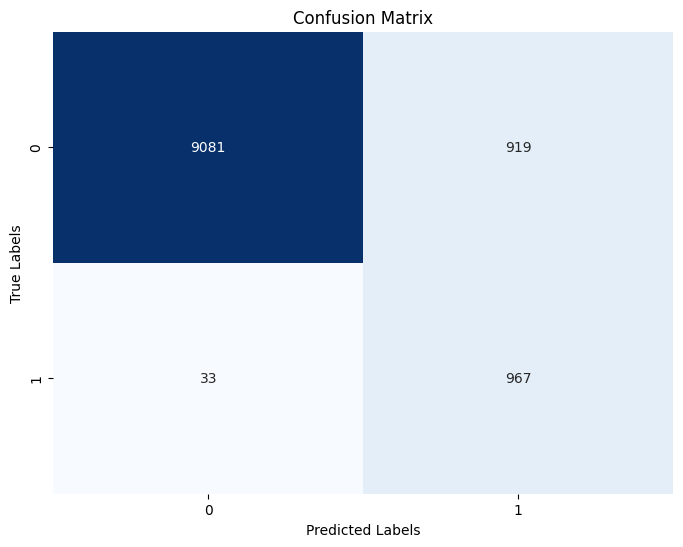

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(test_labels_svm, y_pred_1)

# Create a heatmap visualization of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()